In [160]:
import pandas as pd
from pathlib import Path
from Bio import AlignIO
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.Blast import NCBIWWW, NCBIXML
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import re

from src.sup_data_to_fasta import load_xlsx

sup5_file_path = Path("data/Liu_sup5_data.xlsx")
aligments_files_paths = [
    Path("output/EP-OD0_alignments_results.tsv"),
    Path("output/ESP-OD2_alignments_results.tsv"),
    Path("output/SP-OD2_alignments_results.tsv")
    ]

# Análise Exploratória dos Dados Suplementares 5

## Sobre

Este notebook contém uma análise exploratória dos dados fornecidos por Liu, et al. No [suplemento 5](https://www.nature.com/articles/s41467-023-43632-1#additional-information
) com o objetivo de averiguar os tratamentos executados no artigo

In [183]:
def add_scenario_column(df_dict):
    return {k:df.assign(scenario=k) for k,df in df_dict.items()}

def extract_scenario_from_file_path(string_arg):
    return re.search(r"(.*)-(.*)", string_arg).group(1)

def concat_df_dict(df_dict):
    return pd.concat(df_dict.values())

aligments_df_list = [pd.read_csv(file_path, sep='\t') for file_path in aligments_files_paths]
aligments_df_dict = {extract_scenario_from_file_path(k.name):v for k,v in zip(aligments_files_paths, aligments_df_list)}
aligments_df_dict = add_scenario_column(aligments_df_dict)
aligments_df = concat_df_dict(aligments_df_dict)

sup5_data_df_dict = load_xlsx(sup5_file_path)
sup5_data_df_dict = {extract_scenario_from_file_path(k):v for k,v in sup5_data_df_dict.items()}
sup5_data_df_dict = add_scenario_column(sup5_data_df_dict)
sup5_data_df = concat_df_dict(sup5_data_df_dict)

In [162]:
aligments_df.head()

,Query_ID,Subject_ID,PIdentity,Alignment_Length,Mismatches,Gap_Openings,Query_Start,Query_End,Subject_Start,Subject_End,E_value,Bit_Score,scenario
0,PinT(ncRNA0162),NC_003197.2,100.0,73,0,0,1,73,4559216,4559288,3.410000e-33,135.0,EP
1,STnc2110(ncRNA0286),NC_003197.2,100.0,98,0,0,1,98,4009441,4009344,5.910000e-47,182.0,EP
2,ArcZ(ncRNA0002),NC_003197.2,100.0,59,0,0,1,59,3490451,3490509,1.450000e-25,110.0,EP
3,Spf(ncRNA0075),NC_003197.2,100.0,74,0,0,1,74,4209115,4209188,9.150000e-34,137.0,EP
4,MgrR(ncRNA0043),NC_003197.2,100.0,80,0,0,1,80,1593904,1593983,4.770000e-37,148.0,EP


In [165]:
aligments_df.describe()

print(aligments_df.scenario.value_counts())
print(aligments_df.scenario.nunique())

scenario
EP    6036
Name: count, dtype: int64
1


In [151]:
def should_be_only_one_genome(df):
    return df.Subject_ID.nunique() == 1

def query_start_should_always_be_less_than_query_end(df):
    return (df.Query_Start <= df.Query_End).all()

def end_minus_start_should_equal_length(df):
    return ((df.Query_End - df.Query_Start + 1) == df.Alignment_Length).all()

def aligned_length_should_equal_over_query_and_subject_seqs(df):
    return ((df.Query_End - df.Query_Start) == (df.Subject_End - df.Subject_Start)).all()

# validationg
assert should_be_only_one_genome(aligments_df), "o banco de dados deveria ter apenas um genoma de referência de Salmonella" # all alignments are done to same Salmonella enterica genome
assert query_start_should_always_be_less_than_query_end(aligments_df), "O ínicio da query deve ser menor ou igual ao fim da query"
# assert end_minus_start_should_equal_length(aligments_df), "O tamanho da query deve ser igual a diferença entre o ínicio e o fim da query + 1"
# assert aligned_length_should_equal_over_query_and_subject_seqs(aligments_df), "trecho alinhado deve ter o mesmo tamanho sovbre a query e o subject"

AssertionError: trecho alinhado deve ter o mesmo tamanho sovbre a query e o subject

In [154]:
fig = plt.figure(figsize=(10, 5))
sns.histplot(data=aligments_df, hue='Scenario', bins=10)
plt.xlabel('Scenario')
plt.ylabel('Matches Count')
plt.title('Histogram of Matches Count for Each Scenario')
plt.show()


ValueError: Could not interpret value `Scenario` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x500 with 0 Axes>

Pelo histograma da contagem de alinhamentos por query, observamos que cerca de 30% das queries foram alinhadas uma única vez (0dB). com alguns outliners tendo na ordem de 1000 alinhamentos difrentes.

> hipótese: sequências menores vão retornar maior número de alinhamentos

In [59]:
alignments_count = aligments_df.groupby('Query_ID').size()
avg_length = aligments_df.groupby('Query_ID')['Avg_Alignment_Length'].mean()
per_query_df = pd.DataFrame({'alignments_count': alignments_count, 'avg_length': avg_length})

<Figure size 1000x500 with 0 Axes>

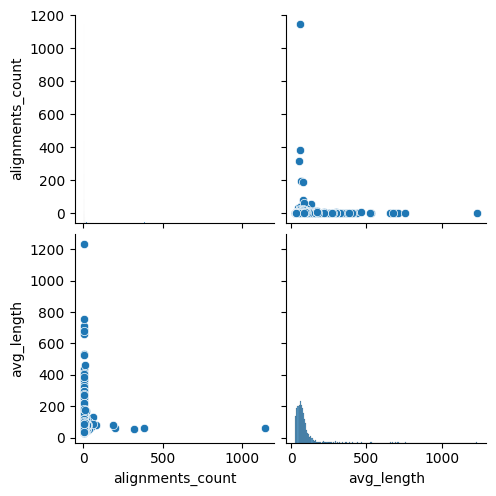

In [65]:
fig = plt.figure(figsize=(10, 5))
sns.pairplot(data=per_query_df, vars=['alignments_count', 'avg_length'])
plt.show()
